<a href="https://colab.research.google.com/github/akshitt/GAN/blob/main/Vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [ ]:
#Using GPU
print(sys.version)
device = 'cuda'
#Checking for GPU
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.is_available())

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
10.1
1
True


In [ ]:
def mnist_data():
  compose = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
  return datasets.MNIST(root='./data', train = True, transform=compose, download=True)

data = mnist_data()

batch = 128
data_loader = DataLoader(data, batch_size=batch, shuffle =True)
num_batches = len(data_loader)
print(num_batches)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
469


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



torch.Size([128, 1, 28, 28])


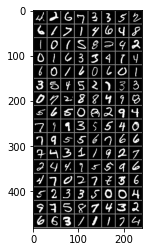

In [ ]:
#display some images 
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  #plt.imshow(np.transpose(img, (1, 2, 0)))
  #print(img.shape)
  img =img/2 +0.5
  npimg = img.cpu().numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
  plt.show()

dataiter = iter(data_loader)
images, labels = dataiter.next()

print(images.shape)
imshow(torchvision.utils.make_grid(images))
#print(' '.join('%10s' % [labels[i]] for i in range(4)))

In [ ]:
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    self.hidden0 = nn.Sequential(
        nn.Linear(784, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3)
    )
    self.out = nn.Sequential(
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

discriminator = DiscriminatorNet().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)

In [ ]:
def images_to_vectors(images):
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)

In [ ]:
class GeneratorNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.hidden0 = nn.Sequential(
        nn.Linear(100, 256),
        nn.LeakyReLU(0.2)  
    )
    self.hidden1 = nn.Sequential(
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2)
    )
    self.hidden2 = nn.Sequential(
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2)
    )
    self.out = nn.Sequential(
        nn.Linear(1024, 784),
        nn.Tanh()
    )
    

  def forward(self, x):
    #print(x)
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

generator = GeneratorNet().to(device)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)

loss = nn.BCELoss()

In [ ]:
def noise(size):
  n = Variable(torch.randn(size, 100))
  return n.to(device)

In [ ]:
def ones_target(size):
  data = Variable(torch.ones(size, 1))
  return data.to(device)

def zeros_target(size):
  data = Variable(torch.zeros(size, 1))
  return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  N = real_data.size(0)
  optimizer.zero_grad()

  prediction_real = discriminator(real_data).to(device)
  loss_real = loss(prediction_real, ones_target(N))
  loss_real.backward()

  prediction_fake = discriminator(fake_data).to(device)
  loss_fake = loss(prediction_fake, zeros_target(N))
  loss_fake.backward()

  optimizer.step()

  return loss_real+loss_fake, prediction_real, prediction_fake

In [ ]:
def train_generator(optimizer, fake_data):
  N = fake_data.size(0)
  optimizer.zero_grad()

  prediction_fake = discriminator(fake_data).to(device)
  loss_gen = loss(prediction_fake, ones_target(N))
  loss_gen.backward()

  optimizer.step()

  return loss_gen

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [ ]:
def fit(num_epochs = 200):
  G_losses = []
  D_losses = []
  for epoch in range(num_epochs):
    d_loss = 0
    g_loss = 0
    for num_iter, (real_batch, _) in enumerate(data_loader):
      #print(real_batch.size(0))
      N = real_batch.size(0)
      #print(noise(N))

      real_data = Variable(images_to_vectors(real_batch)).to(device)
      fake_data = generator(noise(N)).to(device)
      d_loss_now, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data.detach())
      d_loss += d_loss_now

      fake_data = generator(noise(N)).to(device)
      g_loss_now = train_generator(g_optimizer, fake_data)
      g_loss += g_loss_now

    D_losses.append(d_loss)
    G_losses.append(g_loss)
    print("Epoch no - " + str(epoch+1))
    print("Discriminator Loss : %f \t Generator_loss : %f" % (d_loss.item(), g_loss.item()))
    print("Accuracy on Real Data : %f \t Accuracy on fake Data : %f" % (d_pred_real.mean().item(), d_pred_fake.mean().item()))
    #lr_scheduler_d.step(d_loss/N)
    #lr_scheduler_g.step(g_loss/N)

    if((epoch+1)%10 ==0):
      with torch.no_grad():
        generated_data = generator(test_noise.detach())
        imshow(torchvision.utils.make_grid(vectors_to_images(generated_data)))

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(G_losses,label="G")
  plt.plot(D_losses,label="D")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
    


Epoch no - 1
Discriminator Loss : 347.701294 	 Generator_loss : 2069.661865
Accuracy on Real Data : 0.862066 	 Accuracy on fake Data : 0.228249
Epoch no - 2
Discriminator Loss : 256.311615 	 Generator_loss : 2934.624023
Accuracy on Real Data : 0.731817 	 Accuracy on fake Data : 0.441450
Epoch no - 3
Discriminator Loss : 343.332306 	 Generator_loss : 1537.776611
Accuracy on Real Data : 0.773373 	 Accuracy on fake Data : 0.390691
Epoch no - 4
Discriminator Loss : 366.044647 	 Generator_loss : 1216.537109
Accuracy on Real Data : 0.763780 	 Accuracy on fake Data : 0.305429
Epoch no - 5
Discriminator Loss : 237.539078 	 Generator_loss : 1576.604248
Accuracy on Real Data : 0.893691 	 Accuracy on fake Data : 0.194319
Epoch no - 6
Discriminator Loss : 194.079163 	 Generator_loss : 1620.407837
Accuracy on Real Data : 0.786781 	 Accuracy on fake Data : 0.255759
Epoch no - 7
Discriminator Loss : 187.395416 	 Generator_loss : 1666.963257
Accuracy on Real Data : 0.910509 	 Accuracy on fake Data : 0

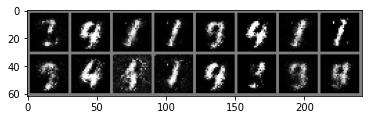

Epoch no - 11
Discriminator Loss : 224.303497 	 Generator_loss : 1398.990479
Accuracy on Real Data : 0.837900 	 Accuracy on fake Data : 0.105107
Epoch no - 12
Discriminator Loss : 238.733002 	 Generator_loss : 1317.450562
Accuracy on Real Data : 0.820676 	 Accuracy on fake Data : 0.212818
Epoch no - 13
Discriminator Loss : 276.630341 	 Generator_loss : 1211.743042
Accuracy on Real Data : 0.692671 	 Accuracy on fake Data : 0.128076
Epoch no - 14
Discriminator Loss : 306.219910 	 Generator_loss : 1090.984619
Accuracy on Real Data : 0.842421 	 Accuracy on fake Data : 0.181209
Epoch no - 15
Discriminator Loss : 304.547760 	 Generator_loss : 1113.664062
Accuracy on Real Data : 0.817074 	 Accuracy on fake Data : 0.253977
Epoch no - 16
Discriminator Loss : 313.398041 	 Generator_loss : 1090.902710
Accuracy on Real Data : 0.780055 	 Accuracy on fake Data : 0.114504
Epoch no - 17
Discriminator Loss : 312.554840 	 Generator_loss : 1074.829834
Accuracy on Real Data : 0.747880 	 Accuracy on fake D

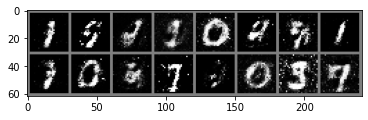

Epoch no - 21
Discriminator Loss : 367.574158 	 Generator_loss : 926.697327
Accuracy on Real Data : 0.796298 	 Accuracy on fake Data : 0.200956
Epoch no - 22
Discriminator Loss : 362.553589 	 Generator_loss : 937.769226
Accuracy on Real Data : 0.744958 	 Accuracy on fake Data : 0.300612
Epoch no - 23
Discriminator Loss : 369.719116 	 Generator_loss : 915.624634
Accuracy on Real Data : 0.705079 	 Accuracy on fake Data : 0.237358
Epoch no - 24
Discriminator Loss : 396.240387 	 Generator_loss : 826.481812
Accuracy on Real Data : 0.764733 	 Accuracy on fake Data : 0.272040
Epoch no - 25
Discriminator Loss : 384.505280 	 Generator_loss : 859.224915
Accuracy on Real Data : 0.715385 	 Accuracy on fake Data : 0.249185
Epoch no - 26
Discriminator Loss : 397.309937 	 Generator_loss : 821.967529
Accuracy on Real Data : 0.759967 	 Accuracy on fake Data : 0.263523
Epoch no - 27
Discriminator Loss : 401.549622 	 Generator_loss : 819.877869
Accuracy on Real Data : 0.692817 	 Accuracy on fake Data : 0

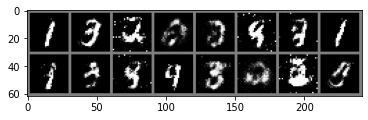

Epoch no - 31
Discriminator Loss : 421.540527 	 Generator_loss : 772.435181
Accuracy on Real Data : 0.680270 	 Accuracy on fake Data : 0.258125
Epoch no - 32
Discriminator Loss : 436.628601 	 Generator_loss : 730.607788
Accuracy on Real Data : 0.660923 	 Accuracy on fake Data : 0.294191
Epoch no - 33
Discriminator Loss : 446.119110 	 Generator_loss : 714.478577
Accuracy on Real Data : 0.776975 	 Accuracy on fake Data : 0.347029
Epoch no - 34
Discriminator Loss : 452.190308 	 Generator_loss : 713.820923
Accuracy on Real Data : 0.670972 	 Accuracy on fake Data : 0.268426
Epoch no - 35
Discriminator Loss : 438.603851 	 Generator_loss : 735.005005
Accuracy on Real Data : 0.588431 	 Accuracy on fake Data : 0.344139
Epoch no - 36
Discriminator Loss : 448.117065 	 Generator_loss : 719.658630
Accuracy on Real Data : 0.667768 	 Accuracy on fake Data : 0.400432
Epoch no - 37
Discriminator Loss : 444.588409 	 Generator_loss : 713.276489
Accuracy on Real Data : 0.662343 	 Accuracy on fake Data : 0

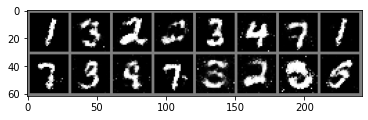

Epoch no - 41
Discriminator Loss : 468.851379 	 Generator_loss : 659.522644
Accuracy on Real Data : 0.735570 	 Accuracy on fake Data : 0.398540
Epoch no - 42
Discriminator Loss : 470.610260 	 Generator_loss : 660.588501
Accuracy on Real Data : 0.724542 	 Accuracy on fake Data : 0.278364
Epoch no - 43
Discriminator Loss : 484.985321 	 Generator_loss : 618.250305
Accuracy on Real Data : 0.627430 	 Accuracy on fake Data : 0.318492
Epoch no - 44
Discriminator Loss : 496.843506 	 Generator_loss : 599.203125
Accuracy on Real Data : 0.629253 	 Accuracy on fake Data : 0.277021
Epoch no - 45
Discriminator Loss : 501.357239 	 Generator_loss : 590.942871
Accuracy on Real Data : 0.633763 	 Accuracy on fake Data : 0.351940
Epoch no - 46
Discriminator Loss : 508.007874 	 Generator_loss : 578.729736
Accuracy on Real Data : 0.638339 	 Accuracy on fake Data : 0.423497
Epoch no - 47
Discriminator Loss : 513.509888 	 Generator_loss : 571.246887
Accuracy on Real Data : 0.605475 	 Accuracy on fake Data : 0

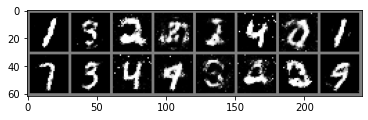

Epoch no - 51
Discriminator Loss : 514.920349 	 Generator_loss : 575.822571
Accuracy on Real Data : 0.700287 	 Accuracy on fake Data : 0.283261
Epoch no - 52
Discriminator Loss : 514.556702 	 Generator_loss : 573.338196
Accuracy on Real Data : 0.628016 	 Accuracy on fake Data : 0.370936
Epoch no - 53
Discriminator Loss : 510.799255 	 Generator_loss : 578.869446
Accuracy on Real Data : 0.672377 	 Accuracy on fake Data : 0.378796
Epoch no - 54
Discriminator Loss : 506.700806 	 Generator_loss : 582.810364
Accuracy on Real Data : 0.659095 	 Accuracy on fake Data : 0.403965
Epoch no - 55
Discriminator Loss : 514.626160 	 Generator_loss : 567.315002
Accuracy on Real Data : 0.629899 	 Accuracy on fake Data : 0.409384
Epoch no - 56
Discriminator Loss : 513.272583 	 Generator_loss : 574.523438
Accuracy on Real Data : 0.616262 	 Accuracy on fake Data : 0.375697
Epoch no - 57
Discriminator Loss : 517.665710 	 Generator_loss : 564.444580
Accuracy on Real Data : 0.618058 	 Accuracy on fake Data : 0

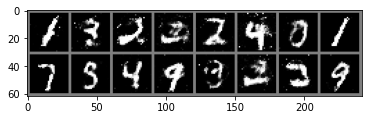

Epoch no - 61
Discriminator Loss : 531.775818 	 Generator_loss : 533.901001
Accuracy on Real Data : 0.642891 	 Accuracy on fake Data : 0.429570
Epoch no - 62
Discriminator Loss : 530.010315 	 Generator_loss : 533.412781
Accuracy on Real Data : 0.617511 	 Accuracy on fake Data : 0.331143
Epoch no - 63
Discriminator Loss : 540.255005 	 Generator_loss : 525.952087
Accuracy on Real Data : 0.665304 	 Accuracy on fake Data : 0.378559
Epoch no - 64
Discriminator Loss : 537.428284 	 Generator_loss : 528.538574
Accuracy on Real Data : 0.602998 	 Accuracy on fake Data : 0.451705
Epoch no - 65
Discriminator Loss : 539.513733 	 Generator_loss : 517.513123
Accuracy on Real Data : 0.576694 	 Accuracy on fake Data : 0.363419
Epoch no - 66
Discriminator Loss : 548.622314 	 Generator_loss : 502.233307
Accuracy on Real Data : 0.649218 	 Accuracy on fake Data : 0.388050
Epoch no - 67
Discriminator Loss : 545.770447 	 Generator_loss : 521.176331
Accuracy on Real Data : 0.582434 	 Accuracy on fake Data : 0

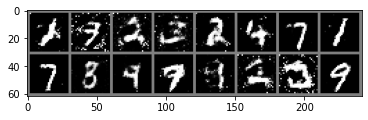

Epoch no - 71
Discriminator Loss : 545.479126 	 Generator_loss : 517.633789
Accuracy on Real Data : 0.627580 	 Accuracy on fake Data : 0.365075
Epoch no - 72
Discriminator Loss : 549.975586 	 Generator_loss : 503.289398
Accuracy on Real Data : 0.524010 	 Accuracy on fake Data : 0.388978
Epoch no - 73
Discriminator Loss : 546.433411 	 Generator_loss : 507.288574
Accuracy on Real Data : 0.575155 	 Accuracy on fake Data : 0.416091
Epoch no - 74
Discriminator Loss : 549.673523 	 Generator_loss : 507.054810
Accuracy on Real Data : 0.592427 	 Accuracy on fake Data : 0.438775
Epoch no - 75
Discriminator Loss : 553.082031 	 Generator_loss : 489.065155
Accuracy on Real Data : 0.636262 	 Accuracy on fake Data : 0.363859
Epoch no - 76
Discriminator Loss : 554.066101 	 Generator_loss : 496.762970
Accuracy on Real Data : 0.614004 	 Accuracy on fake Data : 0.354645
Epoch no - 77
Discriminator Loss : 559.580933 	 Generator_loss : 485.033234
Accuracy on Real Data : 0.572936 	 Accuracy on fake Data : 0

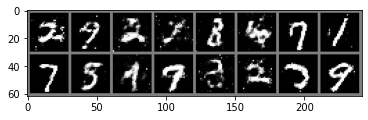

Epoch no - 81
Discriminator Loss : 559.682434 	 Generator_loss : 484.246796
Accuracy on Real Data : 0.646767 	 Accuracy on fake Data : 0.413149
Epoch no - 82
Discriminator Loss : 561.214355 	 Generator_loss : 481.003082
Accuracy on Real Data : 0.618674 	 Accuracy on fake Data : 0.446115
Epoch no - 83
Discriminator Loss : 565.782959 	 Generator_loss : 475.132355
Accuracy on Real Data : 0.563365 	 Accuracy on fake Data : 0.403516
Epoch no - 84
Discriminator Loss : 564.159119 	 Generator_loss : 476.401855
Accuracy on Real Data : 0.639084 	 Accuracy on fake Data : 0.409396
Epoch no - 85
Discriminator Loss : 564.029236 	 Generator_loss : 478.910217
Accuracy on Real Data : 0.608784 	 Accuracy on fake Data : 0.403339
Epoch no - 86
Discriminator Loss : 565.425415 	 Generator_loss : 482.163422
Accuracy on Real Data : 0.602918 	 Accuracy on fake Data : 0.359625
Epoch no - 87
Discriminator Loss : 560.868347 	 Generator_loss : 482.325836
Accuracy on Real Data : 0.616182 	 Accuracy on fake Data : 0

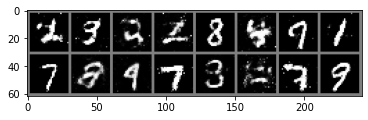

Epoch no - 91
Discriminator Loss : 563.814819 	 Generator_loss : 471.379059
Accuracy on Real Data : 0.593907 	 Accuracy on fake Data : 0.434985
Epoch no - 92
Discriminator Loss : 568.826782 	 Generator_loss : 473.541199
Accuracy on Real Data : 0.614747 	 Accuracy on fake Data : 0.458703
Epoch no - 93
Discriminator Loss : 571.955383 	 Generator_loss : 469.015442
Accuracy on Real Data : 0.535978 	 Accuracy on fake Data : 0.438858
Epoch no - 94
Discriminator Loss : 571.767578 	 Generator_loss : 466.849152
Accuracy on Real Data : 0.556404 	 Accuracy on fake Data : 0.449171
Epoch no - 95
Discriminator Loss : 568.328857 	 Generator_loss : 470.155090
Accuracy on Real Data : 0.532972 	 Accuracy on fake Data : 0.439088
Epoch no - 96
Discriminator Loss : 568.075928 	 Generator_loss : 471.151001
Accuracy on Real Data : 0.583101 	 Accuracy on fake Data : 0.450137
Epoch no - 97
Discriminator Loss : 571.689026 	 Generator_loss : 465.881714
Accuracy on Real Data : 0.585673 	 Accuracy on fake Data : 0

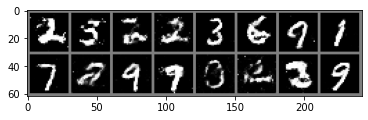

Epoch no - 101
Discriminator Loss : 573.267944 	 Generator_loss : 461.885956
Accuracy on Real Data : 0.564461 	 Accuracy on fake Data : 0.400479
Epoch no - 102
Discriminator Loss : 574.863464 	 Generator_loss : 463.428192
Accuracy on Real Data : 0.650045 	 Accuracy on fake Data : 0.385397
Epoch no - 103
Discriminator Loss : 570.181274 	 Generator_loss : 468.633209
Accuracy on Real Data : 0.566826 	 Accuracy on fake Data : 0.392179
Epoch no - 104
Discriminator Loss : 574.347168 	 Generator_loss : 461.100464
Accuracy on Real Data : 0.544960 	 Accuracy on fake Data : 0.456855
Epoch no - 105
Discriminator Loss : 574.842529 	 Generator_loss : 463.977661
Accuracy on Real Data : 0.600120 	 Accuracy on fake Data : 0.403203
Epoch no - 106
Discriminator Loss : 578.168823 	 Generator_loss : 456.552216
Accuracy on Real Data : 0.503056 	 Accuracy on fake Data : 0.393672
Epoch no - 107
Discriminator Loss : 578.687134 	 Generator_loss : 455.773987
Accuracy on Real Data : 0.611045 	 Accuracy on fake D

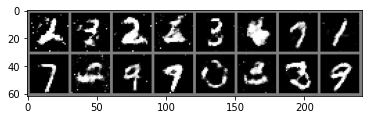

Epoch no - 111
Discriminator Loss : 576.782471 	 Generator_loss : 459.775513
Accuracy on Real Data : 0.546504 	 Accuracy on fake Data : 0.439523
Epoch no - 112
Discriminator Loss : 575.949829 	 Generator_loss : 456.656586
Accuracy on Real Data : 0.586543 	 Accuracy on fake Data : 0.377009
Epoch no - 113
Discriminator Loss : 582.323242 	 Generator_loss : 454.683990
Accuracy on Real Data : 0.584511 	 Accuracy on fake Data : 0.402915
Epoch no - 114
Discriminator Loss : 579.692566 	 Generator_loss : 449.050140
Accuracy on Real Data : 0.585100 	 Accuracy on fake Data : 0.437874
Epoch no - 115
Discriminator Loss : 579.028442 	 Generator_loss : 457.185211
Accuracy on Real Data : 0.553352 	 Accuracy on fake Data : 0.356816
Epoch no - 116
Discriminator Loss : 583.671875 	 Generator_loss : 452.321198
Accuracy on Real Data : 0.570506 	 Accuracy on fake Data : 0.434273
Epoch no - 117
Discriminator Loss : 582.024841 	 Generator_loss : 445.623932
Accuracy on Real Data : 0.578211 	 Accuracy on fake D

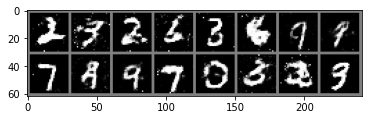

Epoch no - 121
Discriminator Loss : 581.255005 	 Generator_loss : 447.410339
Accuracy on Real Data : 0.566769 	 Accuracy on fake Data : 0.431100
Epoch no - 122
Discriminator Loss : 584.272461 	 Generator_loss : 449.067322
Accuracy on Real Data : 0.571366 	 Accuracy on fake Data : 0.385678
Epoch no - 123
Discriminator Loss : 586.492737 	 Generator_loss : 440.920929
Accuracy on Real Data : 0.573403 	 Accuracy on fake Data : 0.458431
Epoch no - 124
Discriminator Loss : 585.354309 	 Generator_loss : 445.528290
Accuracy on Real Data : 0.600010 	 Accuracy on fake Data : 0.482876
Epoch no - 125
Discriminator Loss : 587.639465 	 Generator_loss : 441.995209
Accuracy on Real Data : 0.561622 	 Accuracy on fake Data : 0.447698
Epoch no - 126
Discriminator Loss : 581.385315 	 Generator_loss : 448.259064
Accuracy on Real Data : 0.500424 	 Accuracy on fake Data : 0.411440
Epoch no - 127
Discriminator Loss : 584.386230 	 Generator_loss : 447.680328
Accuracy on Real Data : 0.586776 	 Accuracy on fake D

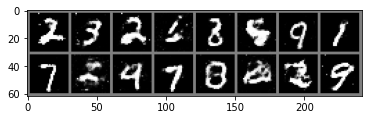

Epoch no - 131
Discriminator Loss : 586.136902 	 Generator_loss : 445.059662
Accuracy on Real Data : 0.553121 	 Accuracy on fake Data : 0.447726
Epoch no - 132
Discriminator Loss : 585.525391 	 Generator_loss : 439.941437
Accuracy on Real Data : 0.567661 	 Accuracy on fake Data : 0.407741
Epoch no - 133
Discriminator Loss : 585.227417 	 Generator_loss : 442.367615
Accuracy on Real Data : 0.549534 	 Accuracy on fake Data : 0.453370
Epoch no - 134
Discriminator Loss : 589.966736 	 Generator_loss : 433.207214
Accuracy on Real Data : 0.541860 	 Accuracy on fake Data : 0.425817
Epoch no - 135
Discriminator Loss : 584.036987 	 Generator_loss : 442.689758
Accuracy on Real Data : 0.593287 	 Accuracy on fake Data : 0.484583
Epoch no - 136
Discriminator Loss : 587.124207 	 Generator_loss : 440.034790
Accuracy on Real Data : 0.596321 	 Accuracy on fake Data : 0.466598
Epoch no - 137
Discriminator Loss : 589.242615 	 Generator_loss : 438.437653
Accuracy on Real Data : 0.537938 	 Accuracy on fake D

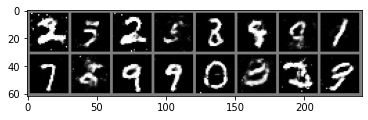

Epoch no - 141
Discriminator Loss : 592.763611 	 Generator_loss : 432.250885
Accuracy on Real Data : 0.520559 	 Accuracy on fake Data : 0.421014
Epoch no - 142
Discriminator Loss : 592.685059 	 Generator_loss : 427.070160
Accuracy on Real Data : 0.553627 	 Accuracy on fake Data : 0.472343
Epoch no - 143
Discriminator Loss : 587.896118 	 Generator_loss : 437.019836
Accuracy on Real Data : 0.550302 	 Accuracy on fake Data : 0.404006
Epoch no - 144
Discriminator Loss : 590.544006 	 Generator_loss : 438.133575
Accuracy on Real Data : 0.601296 	 Accuracy on fake Data : 0.461995
Epoch no - 145
Discriminator Loss : 588.036499 	 Generator_loss : 442.925201
Accuracy on Real Data : 0.634956 	 Accuracy on fake Data : 0.411678
Epoch no - 146
Discriminator Loss : 590.980103 	 Generator_loss : 434.391144
Accuracy on Real Data : 0.519154 	 Accuracy on fake Data : 0.384694
Epoch no - 147
Discriminator Loss : 589.934082 	 Generator_loss : 436.804352
Accuracy on Real Data : 0.533673 	 Accuracy on fake D

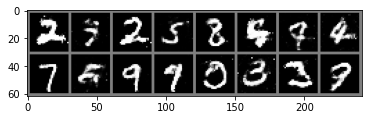

Epoch no - 151
Discriminator Loss : 592.080566 	 Generator_loss : 427.993835
Accuracy on Real Data : 0.510861 	 Accuracy on fake Data : 0.441792
Epoch no - 152
Discriminator Loss : 595.148315 	 Generator_loss : 424.547028
Accuracy on Real Data : 0.557439 	 Accuracy on fake Data : 0.444384
Epoch no - 153
Discriminator Loss : 593.640320 	 Generator_loss : 431.766571
Accuracy on Real Data : 0.554887 	 Accuracy on fake Data : 0.481994
Epoch no - 154
Discriminator Loss : 596.045959 	 Generator_loss : 419.941772
Accuracy on Real Data : 0.566200 	 Accuracy on fake Data : 0.459311
Epoch no - 155
Discriminator Loss : 594.688477 	 Generator_loss : 434.684875
Accuracy on Real Data : 0.564546 	 Accuracy on fake Data : 0.465394
Epoch no - 156
Discriminator Loss : 587.781311 	 Generator_loss : 431.490265
Accuracy on Real Data : 0.549719 	 Accuracy on fake Data : 0.463212
Epoch no - 157
Discriminator Loss : 592.594604 	 Generator_loss : 428.102997
Accuracy on Real Data : 0.567509 	 Accuracy on fake D

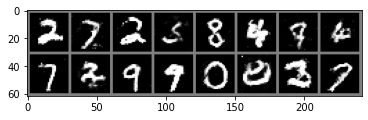

Epoch no - 161
Discriminator Loss : 595.957886 	 Generator_loss : 430.159302
Accuracy on Real Data : 0.541172 	 Accuracy on fake Data : 0.433474
Epoch no - 162
Discriminator Loss : 593.716553 	 Generator_loss : 427.638855
Accuracy on Real Data : 0.585683 	 Accuracy on fake Data : 0.495476
Epoch no - 163
Discriminator Loss : 594.148987 	 Generator_loss : 427.847198
Accuracy on Real Data : 0.557163 	 Accuracy on fake Data : 0.451612
Epoch no - 164
Discriminator Loss : 592.441406 	 Generator_loss : 429.545502
Accuracy on Real Data : 0.561805 	 Accuracy on fake Data : 0.428254
Epoch no - 165
Discriminator Loss : 596.127686 	 Generator_loss : 420.799225
Accuracy on Real Data : 0.541545 	 Accuracy on fake Data : 0.423440
Epoch no - 166
Discriminator Loss : 593.907593 	 Generator_loss : 429.935669
Accuracy on Real Data : 0.556119 	 Accuracy on fake Data : 0.454597
Epoch no - 167
Discriminator Loss : 590.494324 	 Generator_loss : 434.272919
Accuracy on Real Data : 0.591765 	 Accuracy on fake D

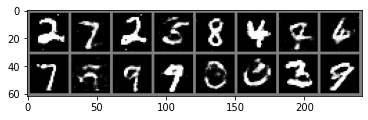

Epoch no - 171
Discriminator Loss : 595.389526 	 Generator_loss : 427.481018
Accuracy on Real Data : 0.498477 	 Accuracy on fake Data : 0.464255
Epoch no - 172
Discriminator Loss : 594.988159 	 Generator_loss : 429.707642
Accuracy on Real Data : 0.556705 	 Accuracy on fake Data : 0.465723
Epoch no - 173
Discriminator Loss : 595.850525 	 Generator_loss : 425.643433
Accuracy on Real Data : 0.541220 	 Accuracy on fake Data : 0.456909
Epoch no - 174
Discriminator Loss : 596.628601 	 Generator_loss : 426.407074
Accuracy on Real Data : 0.547848 	 Accuracy on fake Data : 0.438320
Epoch no - 175
Discriminator Loss : 595.768860 	 Generator_loss : 422.964172
Accuracy on Real Data : 0.551666 	 Accuracy on fake Data : 0.429714
Epoch no - 176
Discriminator Loss : 595.886780 	 Generator_loss : 425.578613
Accuracy on Real Data : 0.561081 	 Accuracy on fake Data : 0.437183
Epoch no - 177
Discriminator Loss : 594.696899 	 Generator_loss : 427.295471
Accuracy on Real Data : 0.541772 	 Accuracy on fake D

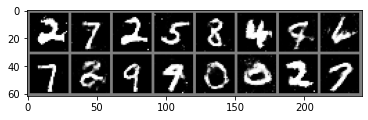

Epoch no - 181
Discriminator Loss : 593.251770 	 Generator_loss : 425.214355
Accuracy on Real Data : 0.551974 	 Accuracy on fake Data : 0.402875
Epoch no - 182
Discriminator Loss : 596.000366 	 Generator_loss : 426.129761
Accuracy on Real Data : 0.558935 	 Accuracy on fake Data : 0.450301
Epoch no - 183
Discriminator Loss : 597.925415 	 Generator_loss : 423.554718
Accuracy on Real Data : 0.581170 	 Accuracy on fake Data : 0.462412
Epoch no - 184
Discriminator Loss : 598.636108 	 Generator_loss : 420.997681
Accuracy on Real Data : 0.588052 	 Accuracy on fake Data : 0.440413
Epoch no - 185
Discriminator Loss : 597.934387 	 Generator_loss : 424.602020
Accuracy on Real Data : 0.546595 	 Accuracy on fake Data : 0.453357
Epoch no - 186
Discriminator Loss : 599.627075 	 Generator_loss : 414.081848
Accuracy on Real Data : 0.541673 	 Accuracy on fake Data : 0.424170
Epoch no - 187
Discriminator Loss : 599.323608 	 Generator_loss : 414.676605
Accuracy on Real Data : 0.596989 	 Accuracy on fake D

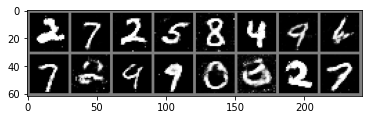

Epoch no - 191
Discriminator Loss : 602.075195 	 Generator_loss : 412.950073
Accuracy on Real Data : 0.584469 	 Accuracy on fake Data : 0.394513
Epoch no - 192
Discriminator Loss : 598.867920 	 Generator_loss : 423.629425
Accuracy on Real Data : 0.570403 	 Accuracy on fake Data : 0.437225
Epoch no - 193
Discriminator Loss : 598.072205 	 Generator_loss : 417.211060
Accuracy on Real Data : 0.574432 	 Accuracy on fake Data : 0.407876
Epoch no - 194
Discriminator Loss : 599.477051 	 Generator_loss : 418.928253
Accuracy on Real Data : 0.524435 	 Accuracy on fake Data : 0.490911
Epoch no - 195
Discriminator Loss : 599.725342 	 Generator_loss : 415.016968
Accuracy on Real Data : 0.603544 	 Accuracy on fake Data : 0.485570
Epoch no - 196
Discriminator Loss : 600.872314 	 Generator_loss : 415.548309
Accuracy on Real Data : 0.551448 	 Accuracy on fake Data : 0.455202
Epoch no - 197
Discriminator Loss : 599.206116 	 Generator_loss : 423.578186
Accuracy on Real Data : 0.519948 	 Accuracy on fake D

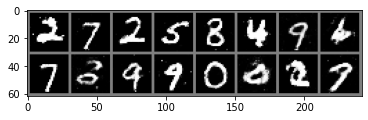

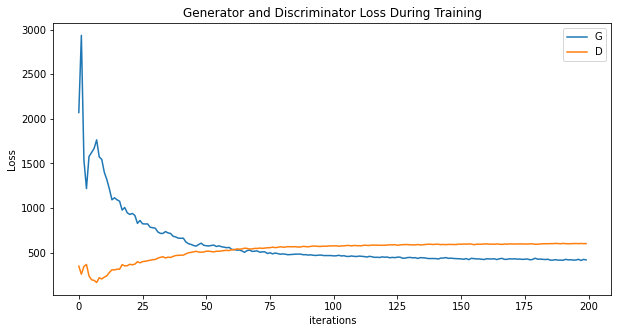

In [ ]:
#lr_scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(d_optimizer, patience=8, verbose=True, eps = 10e-10)
#lr_scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, patience=10, verbose=True, eps = 10e-10)
fit()